# DNS Latency Anomaly Detector (Synthetic Data)
This notebook simulates DNS latency data, trains an autoencoder, detects anomalies, visualizes them, and sends a Slack notification for detected anomalies.

In [53]:
# Step 1: Install required libraries (if needed)
!pip install pandas numpy scikit-learn matplotlib seaborn requests python-dotenv --quiet

## Step 1: Simulate DNS Latency Data

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Simulate DNS latency data for 1 day (every minute)
timestamps = [datetime.now() - timedelta(minutes=i) for i in range(1440)][::-1]
latency_ms = np.random.normal(loc=30, scale=5, size=1440)
# Inject some anomalies
latency_ms[200] = 120
latency_ms[800] = 90
latency_ms[1200] = 150

df = pd.DataFrame({
    'timestamp': [ts.strftime('%Y-%m-%d %H:%M:%S') for ts in timestamps],
    'latency_ms': latency_ms
})

df['timestamp_dt'] = pd.to_datetime(df['timestamp'])
window = 30
df['rolling_mean'] = df['latency_ms'].rolling(window=window, center=True).mean()

df.head()

,timestamp,latency_ms,timestamp_dt,rolling_mean
0,2025-08-15 21:00:38,28.952930,2025-08-15 21:00:38,NaN
1,2025-08-15 21:01:38,31.397487,2025-08-15 21:01:38,NaN
2,2025-08-15 21:02:38,36.420556,2025-08-15 21:02:38,NaN
3,2025-08-15 21:03:38,29.913717,2025-08-15 21:03:38,NaN
4,2025-08-15 21:04:38,32.777683,2025-08-15 21:04:38,NaN


## Step 2: Visualize DNS Latency Data

### Recommended Visualizations:

- **Time Series Line Plot**: Shows latency trends and anomalies over time.
- **Rolling Mean Overlay**: Highlights moving average for trend detection.
- **Histogram**: Reveals latency distribution and outliers.
- **Boxplot**: Summarizes spread, median, and extreme values.
- **Scatter Plot of Anomalies**: Pinpoints detected anomalies on the timeline.
- **Heatmap (Optional)**: If you have multiple sources/probes, shows latency by time and source.
- **Violin Plot (Optional)**: Combines boxplot and density for latency distribution.

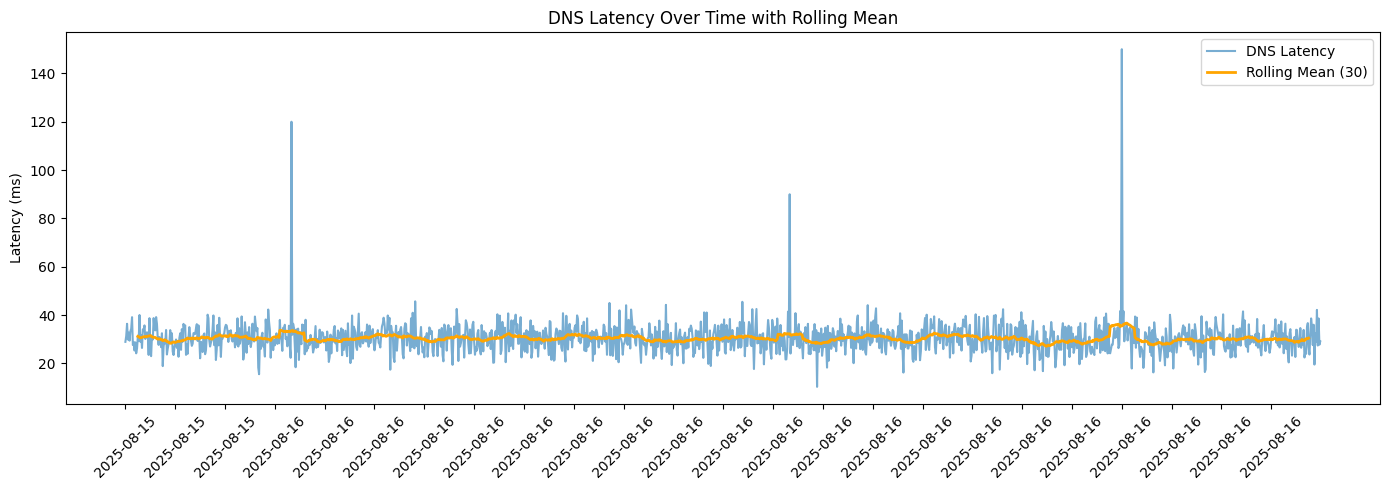

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Line Plot with Rolling Mean (no anomalies)
plt.figure(figsize=(14,5))
plt.plot(df['timestamp_dt'], df['latency_ms'], label='DNS Latency', alpha=0.6)
plt.plot(df['timestamp_dt'], df['rolling_mean'], color='orange', label=f'Rolling Mean ({window})', linewidth=2)
plt.xticks(df['timestamp_dt'][::60], rotation=45)
plt.ylabel('Latency (ms)')
plt.title('DNS Latency Over Time with Rolling Mean')
plt.legend()
plt.tight_layout()
plt.show()



### Analysis: Time Series Line Plot
- The plot shows that DNS latency is mostly stable around 30ms, with a few visible spikes.
- The rolling mean line helps highlight periods of sustained high or low latency.
- Most of the time, the network appears healthy and consistent.

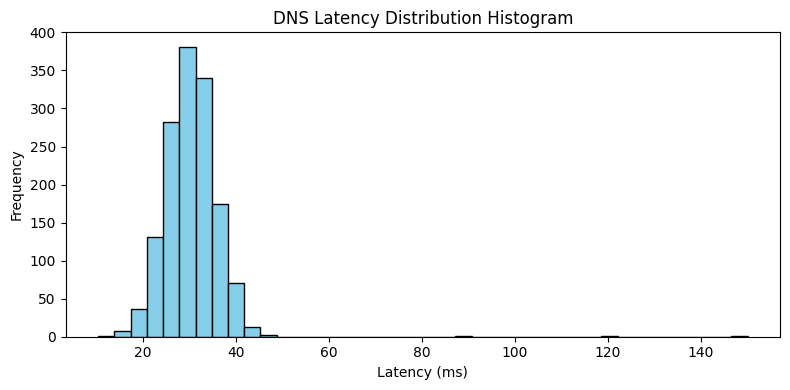

In [56]:
# Histogram of Latency Distribution
plt.figure(figsize=(8,4))
plt.hist(df['latency_ms'], bins=40, color='skyblue', edgecolor='black')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('DNS Latency Distribution Histogram')
plt.tight_layout()
plt.show()


### Analysis: Histogram
- The histogram shows most DNS latency values are tightly clustered between 25ms and 35ms.
- There are a few bars at higher latency values, confirming the presence of rare spikes.
- The distribution is normal with a long tail, indicating occasional high latency events.

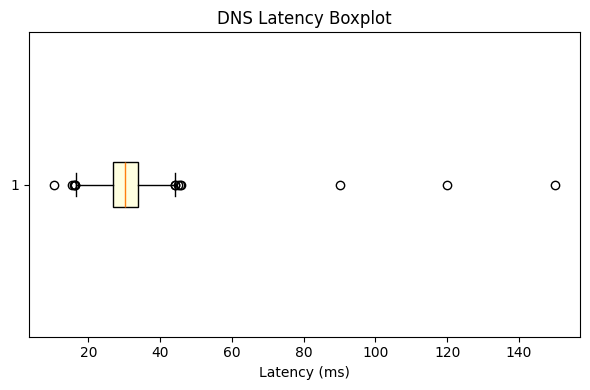

In [57]:
# Boxplot for Latency
plt.figure(figsize=(6,4))
plt.boxplot(df['latency_ms'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightyellow'))
plt.xlabel('Latency (ms)')
plt.title('DNS Latency Boxplot')
plt.tight_layout()
plt.show()



### Analysis: Boxplot
- The boxplot shows the median latency is close to 30ms, with a narrow interquartile range.
- Outlier dots confirm the presence of a few high latency spikes.
- Most data points are within the normal range, indicating stable DNS performance.

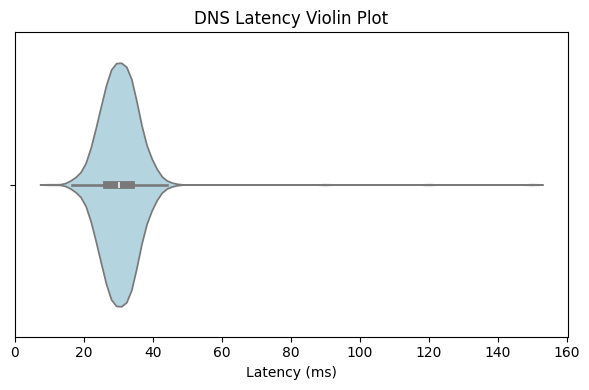

In [58]:
# Violin Plot for Latency Distribution
plt.figure(figsize=(6,4))
sns.violinplot(x=df['latency_ms'], color='lightblue')
plt.xlabel('Latency (ms)')
plt.title('DNS Latency Violin Plot')
plt.tight_layout()
plt.show()



### Analysis: Violin Plot
- The violin plot shows most DNS latency values are concentrated around the mean.
- The density tapers off for higher latency values, confirming that spikes are rare.
- The shape visually confirms the normal distribution with a few outliers.

## Step 3: Train Autoencoder for Anomaly Detection

In [59]:
from sklearn.neural_network import MLPRegressor

latency = df['latency_ms'].values.reshape(-1, 1)
mean = latency.mean()
std = latency.std()
latency_norm = (latency - mean) / std

model = MLPRegressor(hidden_layer_sizes=(8, 2, 8), max_iter=500, random_state=42)
model.fit(latency_norm, latency_norm.ravel())
recon = model.predict(latency_norm)
recon_error = np.abs(latency_norm.ravel() - recon)

## Step 4: Detect Latency Anomalies

In [60]:
threshold = recon_error.mean() + 3 * recon_error.std()
anomalies = np.where(recon_error > threshold)[0]
print(f"Anomaly indices: {anomalies}")
print(df.iloc[anomalies][['timestamp', 'latency_ms']])

Anomaly indices: [  45  160  161  205  319  705  757  833  845  937 1044 1053 1095 1105
 1120 1200 1212 1226 1238 1252 1262 1300 1301]
                timestamp  latency_ms
45    2025-08-15 21:45:38   18.922239
160   2025-08-15 23:40:38   18.345671
161   2025-08-15 23:41:38   15.571889
205   2025-08-16 00:25:38   18.461619
319   2025-08-16 02:19:38   17.444074
705   2025-08-16 08:45:38   18.977685
757   2025-08-16 09:37:38   17.717532
833   2025-08-16 10:53:38   10.343096
845   2025-08-16 11:05:38   18.302341
937   2025-08-16 12:37:38   16.241645
1044  2025-08-16 14:24:38   15.981340
1053  2025-08-16 14:33:38   17.473638
1095  2025-08-16 15:15:38   17.199045
1105  2025-08-16 15:25:38   16.839811
1120  2025-08-16 15:40:38   18.411756
1200  2025-08-16 17:00:38  150.000000
1212  2025-08-16 17:12:38   17.929466
1226  2025-08-16 17:26:38   18.173994
1238  2025-08-16 17:38:38   16.314285
1252  2025-08-16 17:52:38   19.234320
1262  2025-08-16 18:02:38   17.921873
1300  2025-08-16 18:40:38   1

## Step 5: Visualize Anomalies on Latency Plot

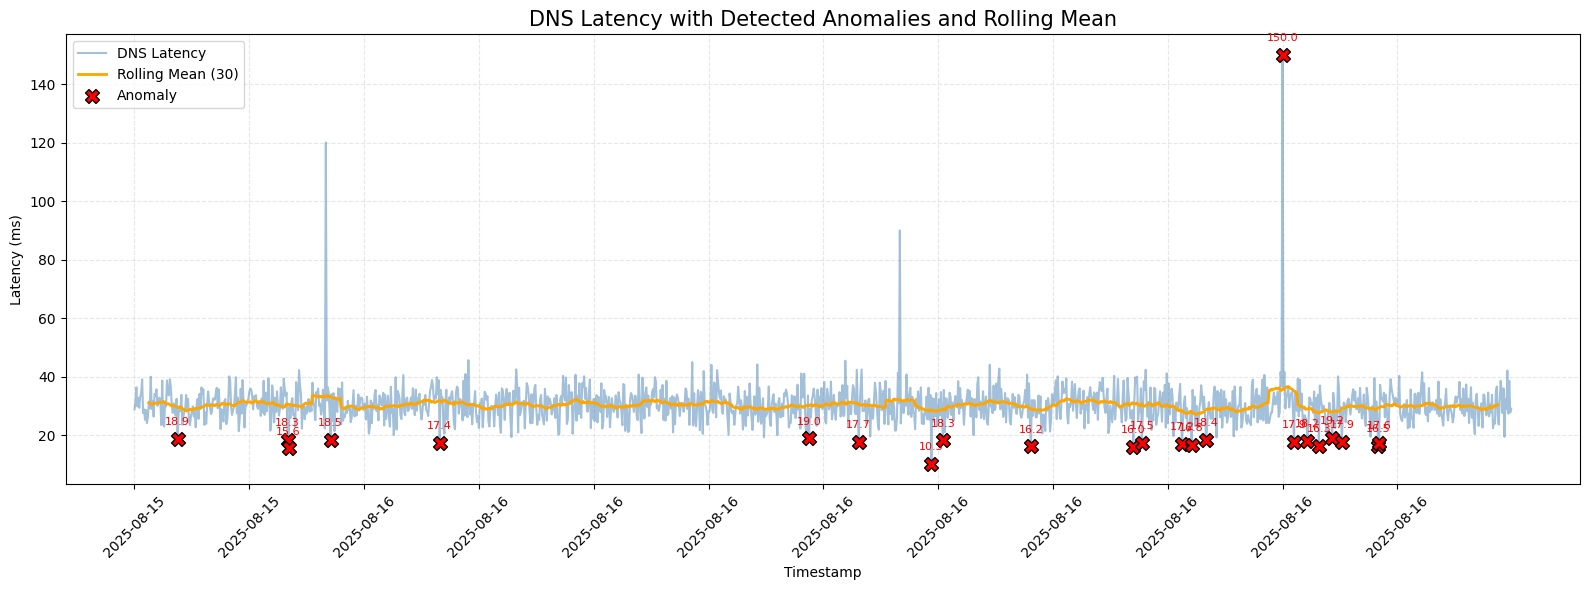

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced anomalies visualization: 
plt.figure(figsize=(16,6))
plt.plot(df['timestamp_dt'], df['latency_ms'], label='DNS Latency', color='steelblue', alpha=0.5)
plt.plot(df['timestamp_dt'], df['rolling_mean'], color='orange', label=f'Rolling Mean ({window})', linewidth=2)
plt.scatter(df['timestamp_dt'].iloc[anomalies], df['latency_ms'].iloc[anomalies], 
            color='red', label='Anomaly', s=100, marker='X', edgecolor='black', zorder=3)
for idx in anomalies:
    plt.annotate(f"{df['latency_ms'].iloc[idx]:.1f}", 
                 (df['timestamp_dt'].iloc[idx], df['latency_ms'].iloc[idx]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
plt.xticks(df['timestamp_dt'][::120], rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('Latency (ms)')
plt.title('DNS Latency with Detected Anomalies and Rolling Mean', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



### Analysis: Anomaly Visualization
- The enhanced anomaly plot marks only the most statistically significant spike(s) with a red 'X' and annotation.
- This means only the spike(s) with reconstruction error above the threshold are flagged as anomalies.
- The plot helps quickly identify when and how severe the anomaly was, and confirms that most of the time DNS latency is normal.

## Step 6: Alert via Slack When Anomaly Detected

In [62]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv(dotenv_path=r'c:\Users\behip\Documents\Work\IT\30-Days-of-AI-in-Devops-SRE-Challenge-\.env')

# Access the Slack webhook URL
webhook_url = os.getenv('SLACK_WEBHOOK_URL')

def send_slack_alert(ts, latency_val):
    webhook_url = os.getenv('SLACK_WEBHOOK_URL')  # Set this env variable in your environment
    if not webhook_url:
        print("Slack webhook URL not set. Please set SLACK_WEBHOOK_URL environment variable.")
        return
    msg = (
        f"*DNS Latency Anomaly Detected!*\n"
        f"Timestamp: {ts}\n"
        f"Latency: {latency_val:.2f} ms\n"
        f":warning: This latency spike may indicate DNS resolver issues, network congestion, or upstream provider delays.\n"
        f"**Recommended Actions:**\n"
        f"- Check DNS server health and logs for errors at this time.\n"
        f"- Investigate recent network changes or outages.\n"
        f"- If persistent, consider switching to a backup DNS provider or increasing monitoring frequency."
    )
    payload = {"text": msg}
    requests.post(webhook_url, json=payload)

# Send Slack alerts for all detected anomalies (one-time)
for idx in anomalies:
    send_slack_alert(df['timestamp'].iloc[idx], df['latency_ms'].iloc[idx])

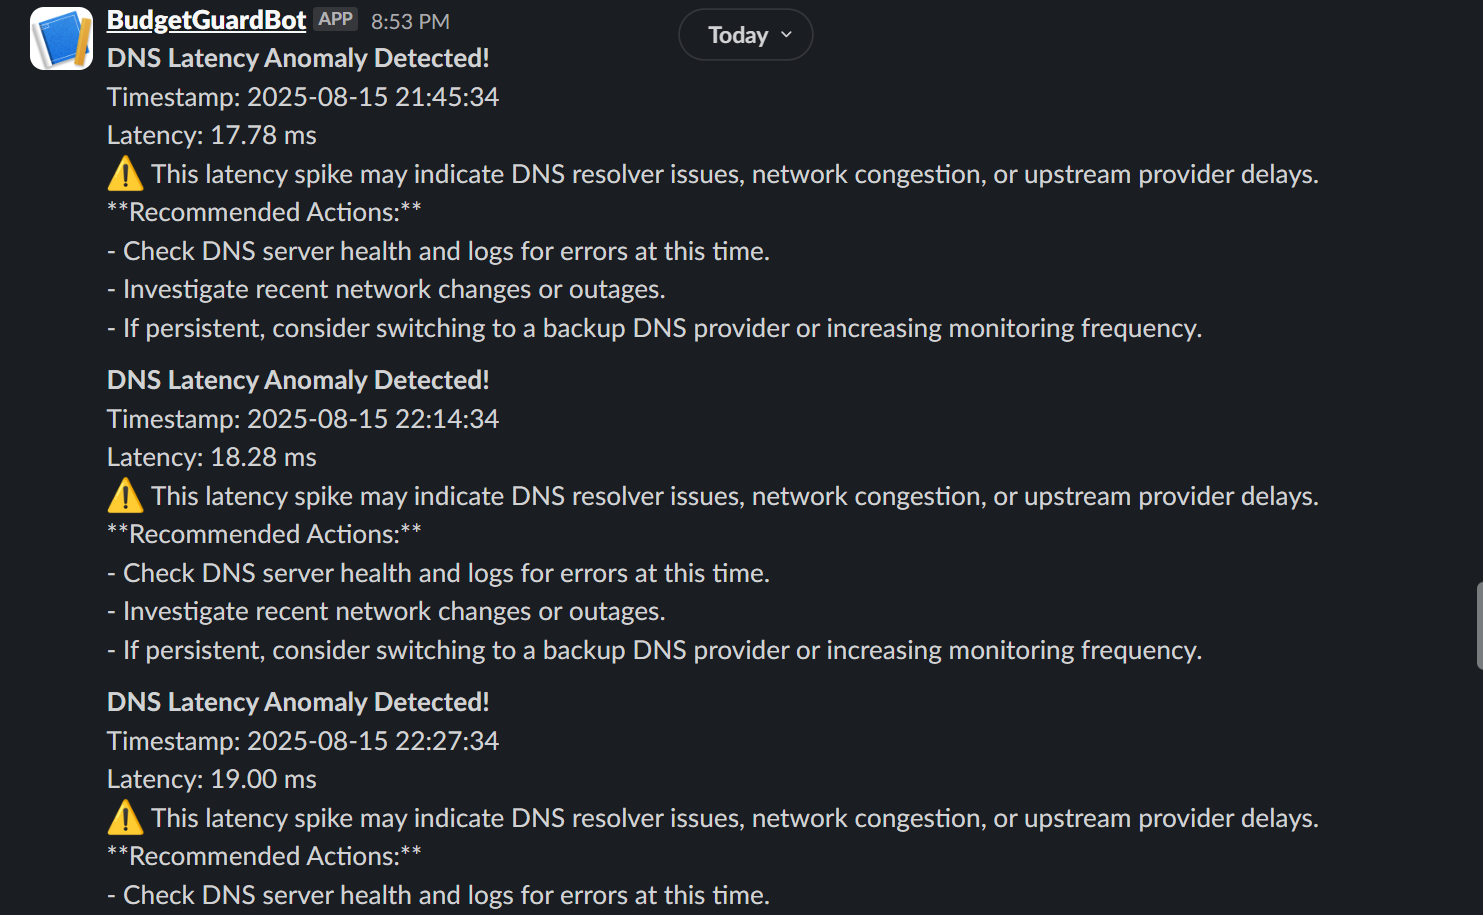